<a href="https://colab.research.google.com/github/ernesto-miguez/Machine-Learning-training/blob/master/Debgugging_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load MNIST Data

In [1]:
# Reset environment for a new run
% reset -f

# Load libraries
from os.path import join
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import unittest
import sys

# Set Pandas display options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# Load data
mnistDf_backup = pd.read_csv(
   "https://download.mlcc.google.com/mledu-datasets/mnist_train_small.csv",
  sep=",",
  header=None) 
# Shuffle data
mnistDf_backup.sample(frac=1).reset_index(drop=True)
# Use the first 5000 examples for faster prototyping
mnistDf = mnistDf_backup[0:5000]

mnistDf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 2. Check if we have imbalanced classes in the data

(array([499., 571., 504., 487., 464., 434., 491., 550., 485., 515.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

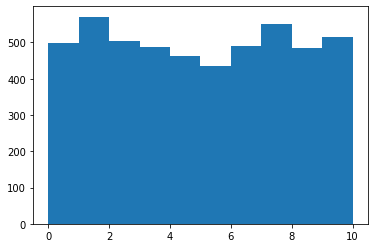

In [2]:
# Calculate the number of classes
numClasses = mnistDf.iloc[:,0].unique().shape[0]
# Plot histogram of class distribution
plt.hist(mnistDf.iloc[:,0], bins=range(numClasses+1))

The graph shows that the 10 classes are roughly equally represented

## 3. Shuffle and Split Dataset

In [0]:
# Shuffle data
mnistDf = mnistDf.sample(frac=1).reset_index(drop=True)

# Split dataset into data and labels
mnistData = mnistDf.iloc[:,1:-1].copy(deep=True)
mnistLabels = mnistDf.iloc[:,0].copy(deep=True)

## 4. Process Data
Scale the data values to `[0,1]` since the values ara bounded to ´[0,255]´ and do not contain outliers

In [4]:
def minMaxScaler(arr):
  min = np.min(arr)
  max = np.max(arr)
  arr = (arr-min)/max
  return arr

for featureIdx in range(mnistData.shape[1]):
  mnistData.iloc[:,featureIdx] = minMaxScaler(mnistData.iloc[:,featureIdx])

mnistData.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,0.0,0.0,0.0
mean,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
min,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
25%,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
50%,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
75%,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
max,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,nan,nan,nan


## 5. Debugging NANs

In [0]:
mnistData = mnistDf.iloc[:,1:-1].copy(deep=True)

In [6]:
mnistData.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.2,...,4.9,4.0,2.6,1.6,1.1,0.6,0.3,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.2,0.4,0.5,0.6,0.6,0.7,0.8,0.7,0.5,0.3,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,4.0,2.1,2.6,5.5,...,30.8,28.0,21.9,17.8,14.5,11.1,7.6,4.5,1.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,3.4,5.1,5.4,9.0,9.9,11.2,10.5,12.0,12.0,11.0,9.4,7.7,5.2,1.0,0.6,3.5,0.9,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,253.0,133.0,133.0,253.0,...,255.0,255.0,255.0,255.0,255.0,255.0,253.0,255.0,62.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,190.0,253.0,203.0,253.0,255.0,255.0,254.0,255.0,255.0,253.0,254.0,253.0,254.0,68.0,43.0,244.0,62.0,0.0,0.0,0.0


Because some of the feature columns are all zeros, the scaling function divided by 0 (because `np.max` returns 0). The division by 0 resulted in NaN values. This result shows you how easily NaNs can arise in engineered data. The `describe` function will not detect every occurrence of NaN (or None). Instead,  use the command `DataFrame.isnull().any()`.

In [0]:
# Redefine the scaling function to check for zeros
def minMaxScaler(arr):
  max = np.max(arr)
  if max != 0:
    min = np.min(arr)
    arr = (arr-min)/max
  return arr

# Reload data
mnistData = mnistDf.iloc[:,1:-1].copy(deep=True)

# Scale data 
for featureIdx in range(mnistData.shape[1]):
  mnistData.iloc[:,featureIdx] = minMaxScaler(mnistData.iloc[:,featureIdx])

## 6. Establish a baseline

In [8]:
# The simplest baseline is predicting the most common class, in this case class 1. Let's check the accuracy when always predicting 1
np.sum(mnistLabels==1)*1.0/mnistLabels.shape[0]*100

11.42

## 7. Train a Linear Model

In [0]:
# Define a function to plot our loss and accuracy curves
def showClassificationResults(trainHistory):
  
  # Print final loss and accuracy
  print("Final training loss: " + str(trainHistory.history['loss'][-1]))
  print("Final validation loss: " + str(trainHistory.history['val_loss'][-1]))
  print("Final training accuracy: " + str(trainHistory.history['acc'][-1]))
  print("Final validation accuracy: " + str(trainHistory.history['val_acc'][-1]))

  # Plot loss and accuracy curves
  f = plt.figure(figsize=(10,4))
  axLoss = f.add_subplot(121)
  axAcc = f.add_subplot(122)
  axLoss.plot(trainHistory.history['loss'])
  axLoss.plot(trainHistory.history['val_loss'])
  axLoss.legend(['Training loss', 'Validation loss'], loc='best')
  axLoss.set_xlabel('Training epochs')
  axLoss.set_ylabel('Loss')
  axAcc.plot(trainHistory.history['acc'])
  axAcc.plot(trainHistory.history['val_acc'])
  axAcc.legend(['Training accuracy', 'Validation accuracy'], loc='best')
  axAcc.set_xlabel('Training epochs')
  axAcc.set_ylabel('Accuracy')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Final training loss: 3.328283977508545
Final validation loss: 3.9024446964263917
Final training accuracy: 0.1465
Final validation accuracy: 0.141


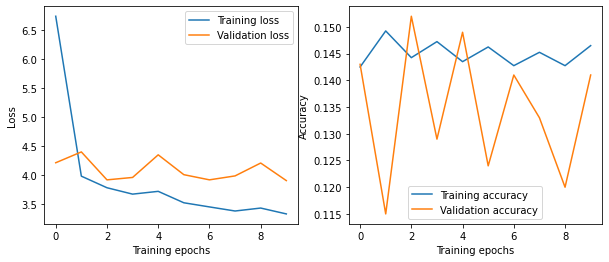

In [10]:
# Train a linear model with an output layer and a hidden layer
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(mnistData.shape[1],
                             activation = 'linear',
                             input_dim=mnistData.shape[1]))
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# Train
trainHistory = model.fit(mnistData, mnistLabels, epochs=10, batch_size=100,
                         validation_split=0.2, verbose=0)

# Plot
showClassificationResults(trainHistory)

In regression the last layer uses a linear activation, but in classification the last layer cannot use a linear transform. Instead, one option is a `softmax` transform.
Furthermore, in regression, the loss is calculated using `MSE` while in classification, loss is calculated using `crossentropy`.
Since the labels are integers instead of one-hot encodings, we use `sparse_categorical_crossentropy` so that we avoid converting the integers to one-hot-encoding 

## 8. Fixing Loss Calculation

Final training loss: 0.1663400454653634
Final validation loss: 0.5042239844799041
Final training accuracy: 0.9537778
Final validation accuracy: 0.878


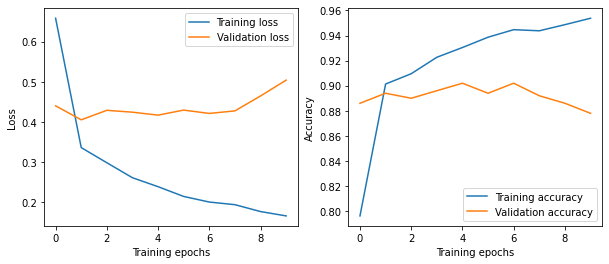

In [11]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(mnistData.shape[1], activation='linear',
                             input_dim = mnistData.shape[1]))
model.add(keras.layers.Dense(10, activation='softmax')) # We set 10 unities because is the number of categories que have in the output
# Compile
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Train
trainHistory = model.fit(mnistData, 
                         mnistLabels, 
                         epochs=10,
                         batch_size = 100, 
                         validation_split = 0.1, 
                         verbose = 0)
# Plot
showClassificationResults(trainHistory)

The model has improved considerably but it still can be better. We can try to improve it by training a nonlinear model

## 9. Train a nonlinear model

Final training loss: 0.004534728969964716
Final validation loss: 0.2755854487419128
Final training accuracy: 1.0
Final validation accuracy: 0.942


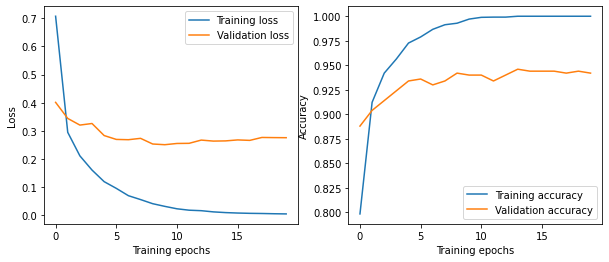

In [12]:
model = None
# Define 
model = keras.Sequential()
model.add(keras.layers.Dense(mnistData.shape[1], activation='relu',
                             input_dim=mnistData.shape[1]))
model.add(keras.layers.Dense(10, activation='softmax'))
# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train
trainHistory = model.fit(mnistData, 
                         mnistLabels,
                         epochs=20,
                         batch_size=100,
                         validation_split=0.1,
                         verbose=0)
# Plot
showClassificationResults(trainHistory)

We can see that the nonlinear model is significantly better than the linear one. The next step could be adding a second relu layer 

## 10. Ading a second relu layer

Final training loss: 0.004046838733160661
Final validation loss: 0.2662651836872101
Final training accuracy: 0.9995555
Final validation accuracy: 0.946


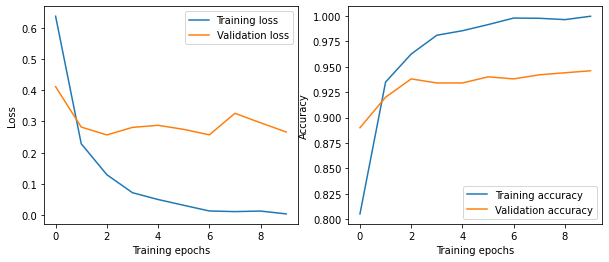

In [13]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(mnistData.shape[1], activation='relu',
                             input_dim=mnistData.shape[1]))
model.add(keras.layers.Dense(mnistData.shape[1], activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))
# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train
trainHistory = model.fit(mnistData,
                         mnistLabels,
                         epochs=10,
                         batch_size=100,
                         validation_split=0.1,
                         verbose=0)
# Plot
showClassificationResults(trainHistory)

The accuracy of the new model (`validation loss = 0.29` and `validation accuracy = 0.94`) is about the same than the previus model with only 1 layer (`validation loss = 0.27` and `validation accuracy = 0.94`). So we are going to use the simpler one.
## 11. Check for Training/Validation Data Skew 


([<matplotlib.axis.XTick at 0x7f188975d908>,
 <a list of 11 Text major ticklabel objects>)

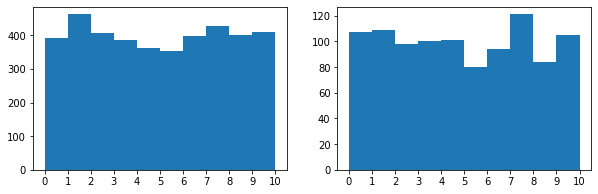

In [14]:
f = plt.figure(figsize=(10,3))
ax = f.add_subplot(1,2,1)
plt.hist(mnistLabels[0:int(len(mnistLabels)*8/10)], bins=range(numClasses+1))
plt.xticks(range(numClasses+1))
ax2 = f.add_subplot(1,2,2,)
plt.hist(mnistLabels[int(len(mnistLabels)*8/10):-1], bins=range(numClasses+1))
plt.xticks(range(numClasses+1))

Our validation accuracy is a little worse than our training accuracy. While this result is always expected, you should check for typical errors. The commonest cause is having different distributions of data and labels in training and validation.
Now we can confirm that the distribution of classes in training and validation data is similar.

## 12. Apply Dropout Regularization

In [0]:
from keras import regularizers
def dropout_reg(dropout_lambda):
  model = None
  # Define model 
  model = keras.Sequential()
  model.add(keras.layers.Dense(mnistData.shape[1],
                              activation='relu',
                              input_dim = mnistData.shape[1]))
  model.add(keras.layers.Dropout(dropout_lambda,
                                noise_shape = (1, mnistData.shape[1])))
  model.add(keras.layers.Dense(10, activation='softmax'))
  # Compile
  model.compile(optimizer='adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  # Train
  trainHistory = model.fit(mnistData,
                          mnistLabels,
                          epochs = 30,
                          batch_size = 500,
                          validation_split = 0.1,
                          verbose = 0)
  # Plot
  return showClassificationResults(trainHistory)

Dropout rate = 0.5
Final training loss: 0.10402004503541523
Final validation loss: 0.259385883808136
Final training accuracy: 0.97488886
Final validation accuracy: 0.936
Dropout rate = 0.4
Final training loss: 0.08183134678337309
Final validation loss: 0.2577519416809082
Final training accuracy: 0.9813333
Final validation accuracy: 0.934
Dropout rate = 0.3
Final training loss: 0.061726452161868416
Final validation loss: 0.24843156337738037
Final training accuracy: 0.98888886
Final validation accuracy: 0.944
Dropout rate = 0.2
Final training loss: 0.042646328194273844
Final validation loss: 0.2663228213787079
Final training accuracy: 0.9955556
Final validation accuracy: 0.942
Dropout rate = 0.1
Final training loss: 0.02956859643260638
Final validation loss: 0.2697063982486725
Final training accuracy: 0.99844444
Final validation accuracy: 0.94


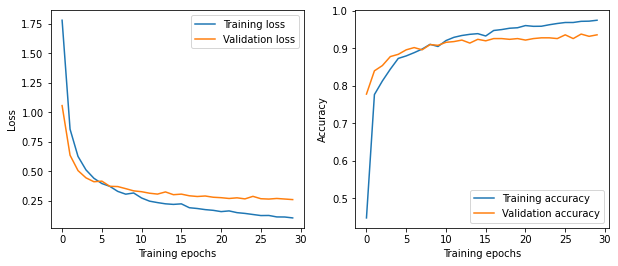

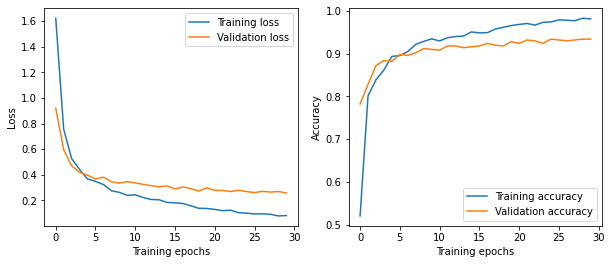

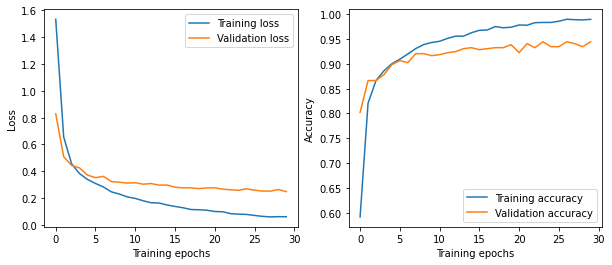

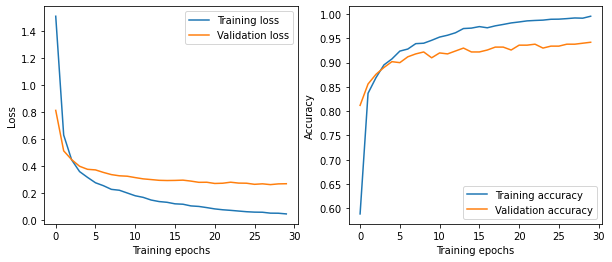

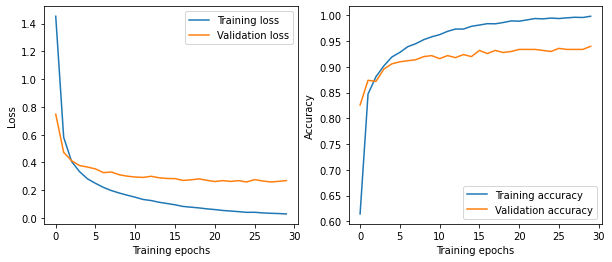

In [23]:
print("Dropout rate = 0.5")
dropout_reg(0.5)
print("Dropout rate = 0.4") 
dropout_reg(0.4)
print("Dropout rate = 0.3") 
dropout_reg(0.3)
print("Dropout rate = 0.2")
dropout_reg(0.2)
print("Dropout rate = 0.1")
dropout_reg(0.1)

Dropout does not improve the results in this case. However, at a dropout of 0.5, the difference in loss decreases, though both training and validation loss decrease in absolute terms
## 13. Check Accuracy for Data Slices

In [24]:
from sklearn.metrics import classification_report
mnistPred = model.predict_classes(mnistData)
print(classification_report(mnistLabels, mnistPred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       499
           1       0.98      0.99      0.98       571
           2       0.97      0.98      0.98       504
           3       0.97      0.98      0.97       487
           4       0.97      0.96      0.97       464
           5       0.99      0.98      0.98       434
           6       1.00      0.99      0.99       491
           7       0.99      0.97      0.98       550
           8       0.98      0.97      0.98       485
           9       0.94      0.97      0.96       515

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



As we can see in the table above, the classification metrics are very uniform across all classes, which is perfect.
## 14. Testing for Anomalous Values

In [25]:
print("Mean of actual labels: " + str(np.mean(mnistLabels)))
print("Standard deviation of actual labels: " + str(np.std(mnistLabels)))

Mean of actual labels: 4.4754
Standard deviation of actual labels: 2.9147546792140053


In [0]:
# Writing tests to check if the mean and standard deviation of the predicted labels falls within the expected range.
class mlTest(unittest.TestCase):

  def testStd(self):
    y = model.predict(mnistData)
    yStd = np.std(y)
    yStdActual = np.std(mnistLabels)
    deltaStd = 0.05
    errorMsg = 'Std. dev of predicted values ' + str(yStd) + \
               ' and actual values ' + str(yStdActual) + \
               ' differs by >' + str(deltaStd) + '.'
    self.assertAlmostEqual(yStd, yStdActual, delta=deltaStd, msg = errorMsg)

  
  def testMean(self):
    y = model.predict(mnistData)
    yMean = np.mean(y)
    yMeanActual = np.mean(mnistLabels)
    deltaMean = 0.05
    errorMsg = 'Mean of predicted values ' + str(yMean) + \
               ' and actual values ' + str(yMeanActual) + \
               ' differs by >' + str(deltaMean) + '.'
    self.assertAlmostEqual(yMean, yMeanActual, delta=deltaMean, msg=errorMsg)

In [28]:
# Train a model with the wrong loss calculation and execute the tests. The tests should fail

model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(mnistData.shape[1],
                             activation = 'linear',
                             input_dim = mnistData.shape[1]))
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
# Train
trainHistory = model.fit(mnistData, 
                         mnistLabels,
                         epochs = 10,
                         batch_size = 100,
                         validation_split = 0.1,
                         verbose=0)

suite = unittest.TestLoader().loadTestsFromTestCase(mlTest)
unittest.TextTestRunner(verbosity=1, stream=sys.stderr).run(suite)

FF
FAIL: testMean (__main__.mlTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-26-c87540564453>", line 18, in testMean
    self.assertAlmostEqual(yMean, yMeanActual, delta=deltaMean, msg=errorMsg)
AssertionError: 4.2251406 != 4.4754 within 0.05 delta : Mean of predicted values 4.2251406 and actual values 4.4754 differs by >0.05.

FAIL: testStd (__main__.mlTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-26-c87540564453>", line 9, in testStd
    self.assertAlmostEqual(yStd, yStdActual, delta=deltaStd, msg = errorMsg)
AssertionError: 2.3071399 != 2.9147546792140053 within 0.05 delta : Std. dev of predicted values 2.3071399 and actual values 2.9147546792140053 differs by >0.05.

----------------------------------------------------------------------
Ran 2 tests in 0.963s

FAILED (failures=2)


<unittest.runner.TextTestResult run=2 errors=0 failures=2>

Since the tests fail, check the data distribution of predicted labels for anomalies

(array([269., 562., 740., 761., 670., 671., 517., 444., 203.,  44.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

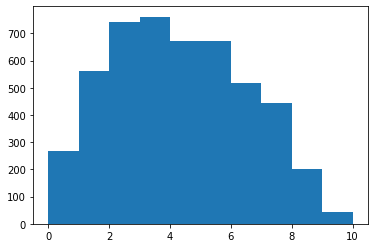

In [29]:
yPred = model.predict(mnistData)
plt.hist(yPred, bins=range(11))

Given equally represented classes, the predicted labels are clearly skewed. A possible explanation is that the loss calculation does not appear to be weighting all classes equally. This anomally might be a hint that your loss calculation is incorrect.
## Pass tests by fixing loss calculation
1. Fix the loss calculation by setting the output layer's activation to `softmax`.
1. Set the model's loss to `sparse_categorical_crossentropy`.
1. Set the number of units in the output layer to 10 corresponding to the 10 classes.
1. Adapt the tests to the modified output layer.


In [53]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(mnistData.shape[1],
                             activation = 'linear',
                             input_dim = mnistData.shape[1]))
#model.add(keras.layers.Dropout(0.5, noise_shape = (1, mnistData.shape[1])))
model.add(keras.layers.Dense(10, activation = 'softmax'))
# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train
trainHistory = model.fit(mnistData,
                         mnistLabels,
                         epochs = 30,
                         batch_size = 500,
                         validation_split = 0.1,
                         verbose=0)
suite = unittest.TestLoader().loadTestsFromTestCase(mlTest)
unittest.TextTestRunner(verbosity=1, stream=sys.stderr).run(suite)

FF
FAIL: testMean (__main__.mlTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-26-c87540564453>", line 18, in testMean
    self.assertAlmostEqual(yMean, yMeanActual, delta=deltaMean, msg=errorMsg)
AssertionError: 0.1 != 4.4754 within 0.05 delta : Mean of predicted values 0.1 and actual values 4.4754 differs by >0.05.

FAIL: testStd (__main__.mlTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-26-c87540564453>", line 9, in testStd
    self.assertAlmostEqual(yStd, yStdActual, delta=deltaStd, msg = errorMsg)
AssertionError: 0.28457293 != 2.9147546792140053 within 0.05 delta : Std. dev of predicted values 0.28457293 and actual values 2.9147546792140053 differs by >0.05.

----------------------------------------------------------------------
Ran 2 tests in 1.251s

FAILED (failures=2)


<unittest.runner.TextTestResult run=2 errors=0 failures=2>

(array([[4.985e+03, 1.500e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [5.000e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [4.993e+03, 7.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [5.000e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [5.000e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [5.000e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [4.997e+03, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [4.989e+03, 1.100e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.

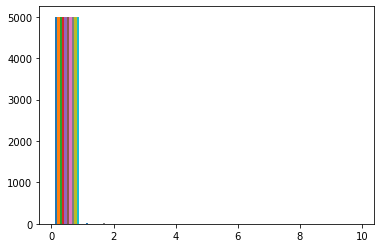

In [52]:
yPred = model.predict(mnistData)
plt.hist(yPred, bins=range(11))